<a href="https://colab.research.google.com/github/JimKing100/SF_Real_Estate_Live/blob/master/Tech_Salary_vs_Housing_Cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Load the tech income data
salary_data = pd.read_csv('https://raw.githubusercontent.com/JimKing100/SF_Real_Estate_Live/master/data/RankedTechIncome.csv')

# Check the data
print(salary_data.shape)
salary_data.head()



(385, 23)


,PRIM_STATE,AREA,AREA_NAME,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC QUOTIENT,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90
0,CA,41940,"San Jose-Sunnyvale-Santa Clara, CA",15-0000,Computer and Mathematical Occupations,major,"141,030",2.3,126.011,4.16,61.08,127040,1.3,32.32,44.19,59.36,75.94,92.45,"67,220","91,910","123,470","157,940","192,300"
1,CA,41860,"San Francisco-Oakland-Hayward, CA",15-0000,Computer and Mathematical Occupations,major,"146,420",2.7,60.525,2,58.04,120730,1.9,31.04,41.69,56.18,71.77,86.49,"64,570","86,710","116,860","149,270","179,900"
2,WA,42660,"Seattle-Tacoma-Bellevue, WA",15-0000,Computer and Mathematical Occupations,major,"139,440",9,70.269,2.32,54.69,113750,6.0,27.98,39.30,54.15,68.71,80.83,"58,200","81,730","112,640","142,920","168,140"
3,DC,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",15-0000,Computer and Mathematical Occupations,major,"232,290",1.7,74.093,2.45,51.81,107760,0.7,28.20,37.27,50.96,64.66,77.77,"58,660","77,520","106,000","134,500","161,750"
4,NH,76900,"Portsmouth, NH-ME",15-0000,Computer and Mathematical Occupations,major,"4,050",3.6,42.949,1.42,50.15,104310,4.4,26.89,35.39,47.64,60.89,74.60,"55,930","73,620","99,090","126,640","155,160"


In [47]:
# Load the median home price data
initial_data = pd.read_csv('https://raw.githubusercontent.com/JimKing100/SF_Real_Estate_Live/master/data/2018MedianHomes-Final.csv')

housing_data = initial_data.rename(columns={'CBSA Code': 'AREA'})

# Check the data
print(housing_data.shape)
housing_data.head()

(180, 5)


,AREA,Metro Area,2016,2017,2018
0,19500,"Decatur, IL",93.3,94.4,90.8
1,49660,"Youngstown-Warren-Boardman, OH-PA",84.4,86.1,94.0
2,19060,"Cumberland, MD-WV",88.8,90.7,100.5
3,21300,"Elmira, NY",116.1,110.4,111.2
4,21500,"Erie, PA",114.9,115.7,118.7


In [48]:
# Merge the data on the common CBSA Code/Area (MSA)
merged_data = pd.merge(salary_data,
                       housing_data,
                       on='AREA')
merged_data.head()

,PRIM_STATE,AREA,AREA_NAME,OCC_CODE,OCC_TITLE,OCC_GROUP,TOT_EMP,EMP_PRSE,JOBS_1000,LOC QUOTIENT,H_MEAN,A_MEAN,MEAN_PRSE,H_PCT10,H_PCT25,H_MEDIAN,H_PCT75,H_PCT90,A_PCT10,A_PCT25,A_MEDIAN,A_PCT75,A_PCT90,Metro Area,2016,2017,2018
0,CA,41940,"San Jose-Sunnyvale-Santa Clara, CA",15-0000,Computer and Mathematical Occupations,major,"141,030",2.3,126.011,4.16,61.08,127040,1.3,32.32,44.19,59.36,75.94,92.45,"67,220","91,910","123,470","157,940","192,300","San Jose-Sunnyvale-Santa Clara, CA",1020.5,1180.0,1340.0
1,CA,41860,"San Francisco-Oakland-Hayward, CA",15-0000,Computer and Mathematical Occupations,major,"146,420",2.7,60.525,2,58.04,120730,1.9,31.04,41.69,56.18,71.77,86.49,"64,570","86,710","116,860","149,270","179,900","San Francisco-Oakland-Hayward, CA",828.0,900.0,987.5
2,WA,42660,"Seattle-Tacoma-Bellevue, WA",15-0000,Computer and Mathematical Occupations,major,"139,440",9,70.269,2.32,54.69,113750,6.0,27.98,39.30,54.15,68.71,80.83,"58,200","81,730","112,640","142,920","168,140","Seattle-Tacoma-Bellevue, WA",414.5,465.8,501.4
3,DC,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",15-0000,Computer and Mathematical Occupations,major,"232,290",1.7,74.093,2.45,51.81,107760,0.7,28.20,37.27,50.96,64.66,77.77,"58,660","77,520","106,000","134,500","161,750","Washington-Arlington-Alexandria, DC-VA-MD-WV",390.6,406.7,424.0
4,NY,35620,"New York-Newark-Jersey City, NY-NJ-PA",15-0000,Computer and Mathematical Occupations,major,"305,470",1.4,32.16,1.06,49.98,103960,0.8,24.89,33.95,47.15,63.10,78.90,"51,760","70,610","98,070","131,260","164,110","New York-Newark-Jersey City, NY-NJ-PA",388.5,404.3,410.0


In [49]:
# Create a subset of the merged data containing only the columns need for the graphs
temp_df = merged_data[['AREA' , 'Metro Area', '2018' , 'A_MEAN']]
temp_df.head()

,AREA,Metro Area,2018,A_MEAN
0,41940,"San Jose-Sunnyvale-Santa Clara, CA",1340.0,127040
1,41860,"San Francisco-Oakland-Hayward, CA",987.5,120730
2,42660,"Seattle-Tacoma-Bellevue, WA",501.4,113750
3,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",424.0,107760
4,35620,"New York-Newark-Jersey City, NY-NJ-PA",410.0,103960


In [50]:
# Rename the columns
final_df = temp_df.rename(columns={'AREA': 'cbsa_code', 'Metro Area': 'metro_area',
                                   '2018': 'median_home_price', 'A_MEAN': 'tech_salary'})
final_df.head()

,cbsa_code,metro_area,median_home_price,tech_salary
0,41940,"San Jose-Sunnyvale-Santa Clara, CA",1340.0,127040
1,41860,"San Francisco-Oakland-Hayward, CA",987.5,120730
2,42660,"Seattle-Tacoma-Bellevue, WA",501.4,113750
3,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",424.0,107760
4,35620,"New York-Newark-Jersey City, NY-NJ-PA",410.0,103960


In [51]:
# Multiply median_home_price by 1,000 to obtain full median home price and convert to integer
final_df.loc[:,'median_home_price'] *= 1000
final_df = final_df.astype({'median_home_price': 'int'})
final_df.head()

,cbsa_code,metro_area,median_home_price,tech_salary
0,41940,"San Jose-Sunnyvale-Santa Clara, CA",1340000,127040
1,41860,"San Francisco-Oakland-Hayward, CA",987500,120730
2,42660,"Seattle-Tacoma-Bellevue, WA",501400,113750
3,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",424000,107760
4,35620,"New York-Newark-Jersey City, NY-NJ-PA",410000,103960


In [52]:
# Function to calculate the monthly housing payment (PITI)
def minimum_income(median_price):
    int_rate = .04
    term = 30
    down_pmt = .20
    principal_pmt = median_price * (1 - down_pmt)
    
    # Calculate insurance and taxes
    tax_pmt = (median_price * .01) / 12
    insurance_pmt = (median_price * .0038) / 12
    
    # monthly rate from annual percentage rate
    interest_rate = int_rate/(100 * 12)
    
    # total number of payments
    payment_num = term * 12
    
    # calculate monthly mortgage payment
    mortgage_pmt = principal_pmt * (interest_rate * (math.pow((1 + interest_rate), (payment_num))) / 
                               (math.pow((1 + interest_rate), (payment_num)) - 1))
    payment = mortgage_pmt + tax_pmt + insurance_pmt
    min_income = (payment / .30) * 12
    
    return min_income

# Create and calculate a min_income column representing the minimum required iincome to buy a median priced home
# This represents the final dataframe for graphing
final_df['min_income'] = final_df.apply(lambda x: minimum_income(x['median_home_price']), axis=1)
final_df = final_df.astype({'min_income': 'int'})
final_df.head()

,cbsa_code,metro_area,median_home_price,tech_salary,min_income
0,41940,"San Jose-Sunnyvale-Santa Clara, CA",1340000,127040,181469
1,41860,"San Francisco-Oakland-Hayward, CA",987500,120730,133731
2,42660,"Seattle-Tacoma-Bellevue, WA",501400,113750,67901
3,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",424000,107760,57420
4,35620,"New York-Newark-Jersey City, NY-NJ-PA",410000,103960,55524


In [53]:
# Create and calculate a differential column representing the difference between tech_salary and min_income
final_df['differential'] = final_df.apply(lambda x: x['tech_salary'] - x['min_income'], axis=1)
final_df.head()

,cbsa_code,metro_area,median_home_price,tech_salary,min_income,differential
0,41940,"San Jose-Sunnyvale-Santa Clara, CA",1340000,127040,181469,-54429
1,41860,"San Francisco-Oakland-Hayward, CA",987500,120730,133731,-13001
2,42660,"Seattle-Tacoma-Bellevue, WA",501400,113750,67901,45849
3,47900,"Washington-Arlington-Alexandria, DC-VA-MD-WV",424000,107760,57420,50340
4,35620,"New York-Newark-Jersey City, NY-NJ-PA",410000,103960,55524,48436


In [54]:
# Simplify the MSA names for the graph
area_dict = {"San Jose-Sunnyvale-Santa Clara, CA": "San Jose, CA", "San Francisco-Oakland-Hayward, CA": "San Francisco, CA",
             "Seattle-Tacoma-Bellevue, WA": "Seattle, WA", "Washington-Arlington-Alexandria, DC-VA-MD-WV": "Washington, DC",
             "New York-Newark-Jersey City, NY-NJ-PA": "New York, NY", "Baltimore-Columbia-Towson, MD": "Baltimore, MD",
             "San Diego-Carlsbad, CA": "San Diego, CA", "Denver-Aurora-Lakewood, CO": "Denver, CO", 
             "Houston-The Woodlands-Sugar Land, TX": "Houston, TX", "Dallas-Fort Worth-Arlington, TX": "Dallas, TX",
             "Austin-Round Rock, TX": "Austin, TX", "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD": "Philadelphia, PA", 
             "Durham-Chapel Hill, NC": "Durham, NC", "Atlanta-Sandy Springs-Marietta, GA": "Atlanta, GA",
             "Davenport-Moline-Rock Island, IA-IL	": "Davenport, IA", "Atlantic City-Hammonton, NJ": "Atlantic City, NJ",
             "Palm Bay-Melbourne-Titusville, FL": "Palm Bay, FL", "Greensboro-High Point, NC": "Greensboro, NC"
            }

final_df = final_df.replace({'metro_area': area_dict})
final_df.head()

,cbsa_code,metro_area,median_home_price,tech_salary,min_income,differential
0,41940,"San Jose, CA",1340000,127040,181469,-54429
1,41860,"San Francisco, CA",987500,120730,133731,-13001
2,42660,"Seattle, WA",501400,113750,67901,45849
3,47900,"Washington, DC",424000,107760,57420,50340
4,35620,"New York, NY",410000,103960,55524,48436


In [55]:
# Sort the data by descending tech_salary and create a top_salaries dataframe using the top 20
top_salaries = final_df.sort_values(by=['tech_salary'], ascending=False)[:20]
top_salaries.head()

,cbsa_code,metro_area,median_home_price,tech_salary,min_income,differential
0,41940,"San Jose, CA",1340000,127040,181469,-54429
1,41860,"San Francisco, CA",987500,120730,133731,-13001
2,42660,"Seattle, WA",501400,113750,67901,45849
3,47900,"Washington, DC",424000,107760,57420,50340
4,35620,"New York, NY",410000,103960,55524,48436


In [56]:
# Create a list of metro areas and a list of tech salaries for graph
metro_area = top_salaries['metro_area'].values.tolist()
print(metro_area)
salary = top_salaries['tech_salary'].values.tolist()
print(salary)

['San Jose, CA', 'San Francisco, CA', 'Seattle, WA', 'Washington, DC', 'New York, NY', 'Baltimore, MD', 'Boulder, CO', 'San Diego, CA', 'Denver, CO', 'Huntsville, AL', 'Colorado Springs, CO', 'Houston, TX', 'Trenton, NJ', 'Dallas, TX', 'Columbus, OH', 'Austin, TX', 'Philadelphia, PA', 'Durham, NC', 'Raleigh, NC', 'Atlanta, GA']
[127040, 120730, 113750, 107760, 103960, 101510, 101220, 99890, 98460, 97340, 95690, 95520, 94190, 93820, 92440, 91970, 91820, 91740, 91680, 91220]


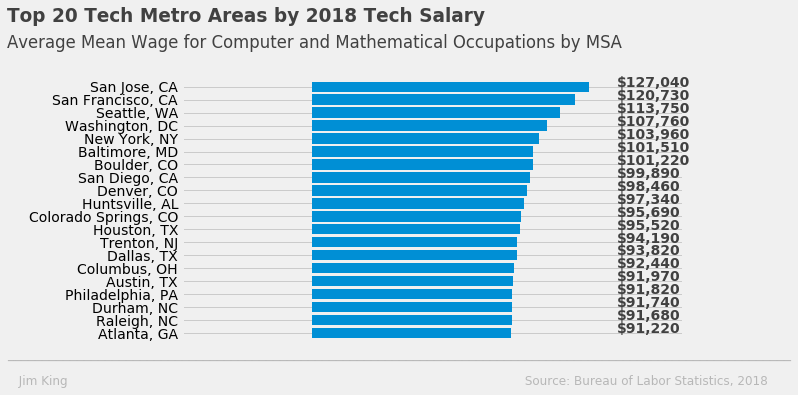

In [57]:
# Create the "Top 20 Tech Metro Areas by 2018 Tech Salary" graph
plt.style.use('fivethirtyeight')

# Setting size of our plot
fig, ax = plt.subplots(figsize=(8,6))

# Load the graph data
areas = np.arange(len(metro_area))
y_pos = areas[::-1]
x_pos = salary[::-1]

# Plot the data
plt.barh(y_pos, salary)

# Y axis past 0 & above 20 -- grid line will pass 0 & 20 marker
plt.ylim(-2,25)
plt.xlim(-60000, 170000)

# Y-labels to only these
plt.yticks(y_pos, metro_area);

# X-labels and changing label names
ax.set_xticks([])

# Plot amounts
for i, v in enumerate(y_pos):
    ax.text(v + 140000, i + 0, '${:,.0f}'.format(x_pos[i]), color='#414141', fontweight='bold')
    
# Title text
ax.text(x=-140000, y=24, s="Top 20 Tech Metro Areas by 2018 Tech Salary", fontsize=18.5, fontweight='semibold', color='#414141')

# Subtitle text
ax.text(x=-140000, y=22, s='Average Mean Wage for Computer and Mathematical Occupations by MSA', fontsize=16.5, color='#414141');

# The signature bar
ax.text(x = -140000, y = -2,
    s = '________________________________________________________________________________________________________________',
    color = 'grey', alpha = .5)

ax.text(x = -140000, y = -4,
    s = '   Jim King                                                                                                                      Source: Bureau of Labor Statistics, 2018   ',
    fontsize = 12, color = 'grey', alpha = .5);

In [58]:
# Sort the data by descending differential
top_salaries = top_salaries.sort_values(by=['differential'], ascending=False)[:20]
top_salaries.head()

,cbsa_code,metro_area,median_home_price,tech_salary,min_income,differential
9,26620,"Huntsville, AL",205400,97340,27816,69524
14,18140,"Columbus, OH",201800,92440,27328,65112
11,26420,"Houston, TX",238800,95520,32339,63181
5,12580,"Baltimore, MD",285600,101510,38677,62833
19,12060,"Atlanta, GA",219900,91220,29779,61441


In [59]:
# Create a list of metro areas and a list of differentials for graph
metro_area = top_salaries['metro_area'].values.tolist()
print(metro_area)
differential = top_salaries['differential'].values.tolist()
print(differential)

['Huntsville, AL', 'Columbus, OH', 'Houston, TX', 'Baltimore, MD', 'Atlanta, GA', 'Trenton, NJ', 'Philadelphia, PA', 'Dallas, TX', 'Durham, NC', 'Colorado Springs, CO', 'Raleigh, NC', 'Washington, DC', 'Austin, TX', 'New York, NY', 'Seattle, WA', 'Denver, CO', 'Boulder, CO', 'San Diego, CA', 'San Francisco, CA', 'San Jose, CA']
[69524, 65112, 63181, 62833, 61441, 60944, 60808, 58610, 53957, 53411, 53274, 50340, 49190, 48436, 45849, 37533, 18963, 14031, -13001, -54429]


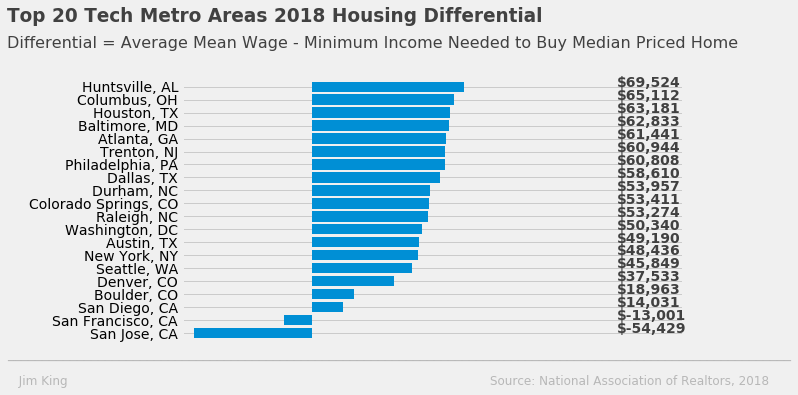

In [60]:
# Create the "Top 20 Tech Metro Areas by 2018 Tech Salary" graph
plt.style.use('fivethirtyeight')

# Setting size of our plot
fig, ax = plt.subplots(figsize=(8,6))

# Load the graph data
areas = np.arange(len(metro_area))
y_pos = areas[::-1]
x_pos = differential[::-1]

# Plot the data
plt.barh(y_pos, differential)

# Y axis past 0 & above 20 -- grid line will pass 0 & 20 marker
plt.ylim(-2,25)
plt.xlim(-60000, 170000)

# Y-labels to only these
plt.yticks(y_pos, metro_area);

# X-labels and changing label names
ax.set_xticks([])

# Plot amounts
for i, v in enumerate(y_pos):
    ax.text(v + 140000, i + 0, '${:,.0f}'.format(x_pos[i]), color='#414141', fontweight='bold')
    
# Title text
ax.text(x=-140000, y=24, s="Top 20 Tech Metro Areas 2018 Housing Differential", fontsize=18.5, fontweight='semibold', color='#414141')

# Subtitle text
ax.text(x=-140000, y=22, s='Differential = Average Mean Wage - Minimum Income Needed to Buy Median Priced Home', fontsize=16, color='#414141');

# The other signature bar
ax.text(x = -140000, y = -2,
    s = '________________________________________________________________________________________________________________',
    color = 'grey', alpha = .5)

ax.text(x = -140000, y = -4,
    s = '   Jim King                                                                                                             Source: National Association of Realtors, 2018   ',
    fontsize = 12, color = 'grey', alpha = .5);